In [19]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats

#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = 'noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(obs):
    cat = np.array(obs['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2499]}

sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]

def find_bounds(k):
    hw = 25 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

In [10]:
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

def simulator_wrapper(params):
    dict_cl = simulator(np.array(params))
    cltt = noise(dict_cl)['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)

observed_dataset = simulator_wrapper(pl)
print(observed_dataset)

tensor([  43.7224, -365.3584, -322.9934,   70.5941, -457.6540],
       dtype=torch.float64)


In [3]:
import pickle 
with open ('samples/samples_10000_sim_wishart.pkl', 'rb') as file:
    sims = pickle.load(file)

In [6]:
print(sims['z'])

[[0.711917   0.023041   0.11872233 3.0918396  0.97982085]
 [0.6924098  0.02245601 0.11850326 3.078536   0.96539575]
 [0.70291185 0.02298943 0.11835913 3.076221   0.961755  ]
 ...
 [0.66881627 0.02228978 0.11936901 3.0744474  0.9652227 ]
 [0.67456114 0.02225137 0.11507641 3.0670178  0.9533433 ]
 [0.6516637  0.02318066 0.12062858 3.0660365  0.9827742 ]]


In [21]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
num_dim = 5

cls = sims['x']
params = sims['z']
print(params[0])

prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(params, dtype = torch.float32), 
                                         torch.tensor(cls, dtype = torch.float32))


[0.711917   0.023041   0.11872233 3.0918396  0.97982085]


In [15]:
density_estimator = inference.train()

 Neural network successfully converged after 156 epochs.

[0.4939921495198738, 0.018399893955357016]


In [23]:
simulator_sbi, prior = prepare_for_sbi(simulator_wrapper, prior)

posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(observed_dataset)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

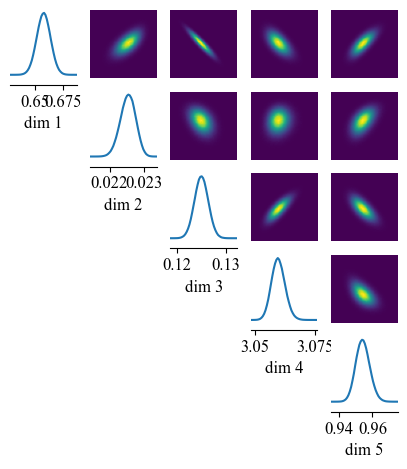

In [12]:
posterior_samples = posterior.sample((1000000,))
from sbi.analysis import pairplot
fig, ax = pairplot(
    samples=posterior_samples,
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

In [13]:
with open ('sbi_samples/samples_npe_moped_10000_1000000.pkl', 'wb') as file:
    pickle.dump(posterior_samples, file)

In [24]:
num_rounds = 4
x_o = observed_dataset

posteriors = []

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=3000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 68 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

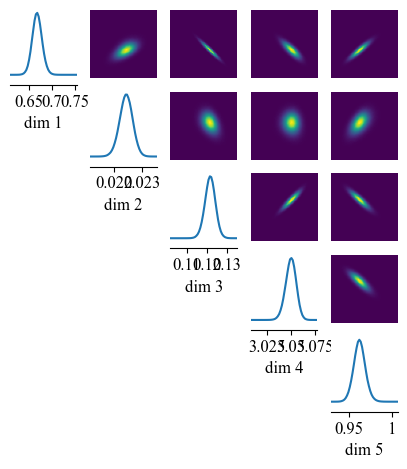

In [25]:
posterior_samples = posteriors[3].sample((1000000,))
from sbi.analysis import pairplot
fig, ax = pairplot(
    samples=posterior_samples,
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

In [27]:
np.save( 'samples/posterior_samples_snpe.npy', posterior_samples)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats
from getdist import plots
from getdist import MCSamples

posterior_samples = np.load('sbi_samples/posterior_samples_snpe.npy')



2024-04-08 10:40:42.670580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Removed no burn in


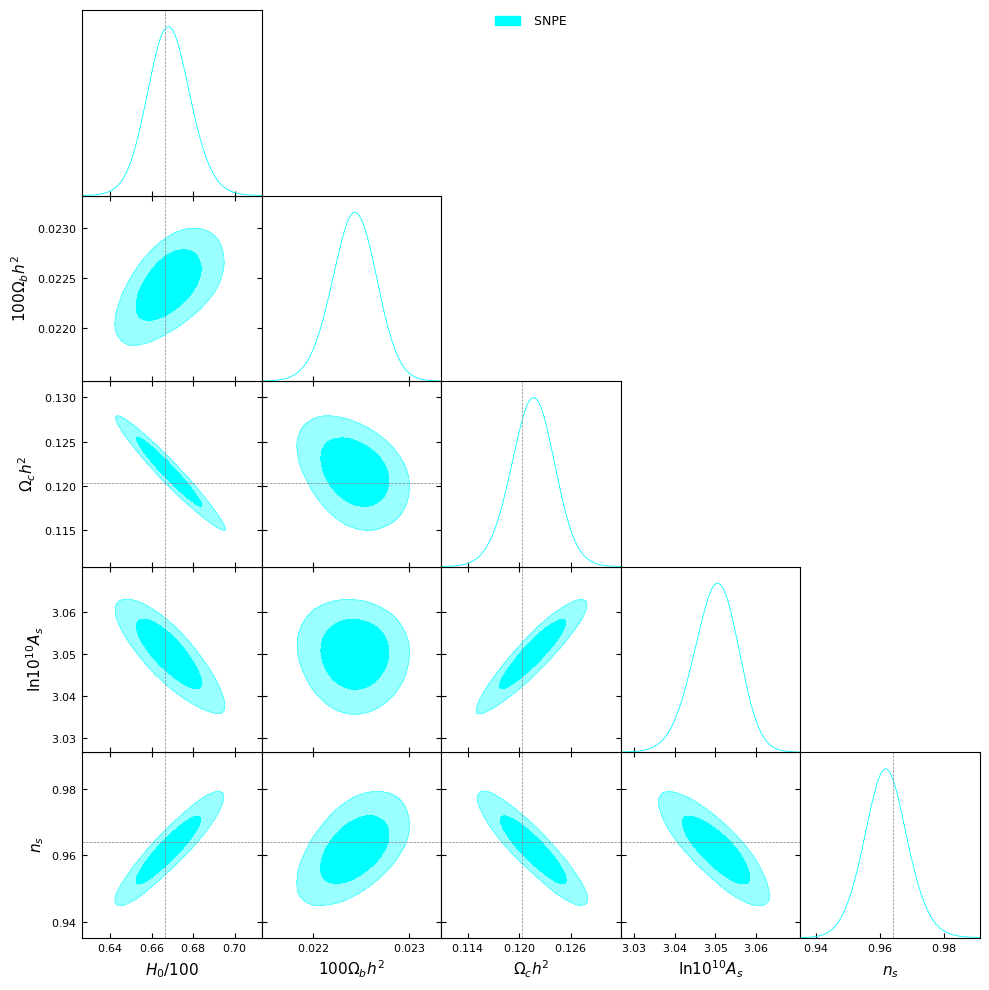

In [3]:
from getdist import plots
from getdist import MCSamples

%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

snpe_samples = MCSamples(samples=posterior_samples, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot(snpe_samples, filled=True, 
                contour_colors = ['cyan'],
                legend_labels=[' SNPE'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}
                
                );

## AGAIN

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats

#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = 'noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(obs):
    cat = np.array(obs['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2499]}

sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]

def find_bounds(k):
    hw = 24 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

In [8]:
print(param_min)
print(param_max)

[0.5012724635390788, 0.018559898197142734, 0.08034454022240717, 2.991962391414518, 0.8652648943279388]
[0.8507275364609213, 0.026240101802857265, 0.15965545977759282, 3.1586376085854817, 1.064735105672061]


In [5]:
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

def simulator_wrapper(params):
    dict_cl = simulator(np.array(params))
    cltt = noise(dict_cl)['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)

observed_dataset = simulator_wrapper(pl)
print(observed_dataset)

tensor([  41.1488, -374.3914, -330.1941,   82.9168, -457.3451],
       dtype=torch.float64)


In [6]:
prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

simulator_sbi, prior = prepare_for_sbi(simulator_wrapper, prior)

inference = SNPE(prior=prior)

In [10]:
prior.sample()[1]

tensor(0.0216)

In [11]:
num_rounds = 2
x_o = observed_dataset

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=3000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

import pickle
with open('sbi_posteriors/posteriors_snpe_3_rounds_3000sim.pkl', 'wb') as file:
    pickle.dump(posteriors, file)

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

 Neural network successfully converged after 277 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

In [15]:
posterior_samples1 = posteriors[-1].sample((1000000,))
posterior_samples0 = posteriors[0].sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


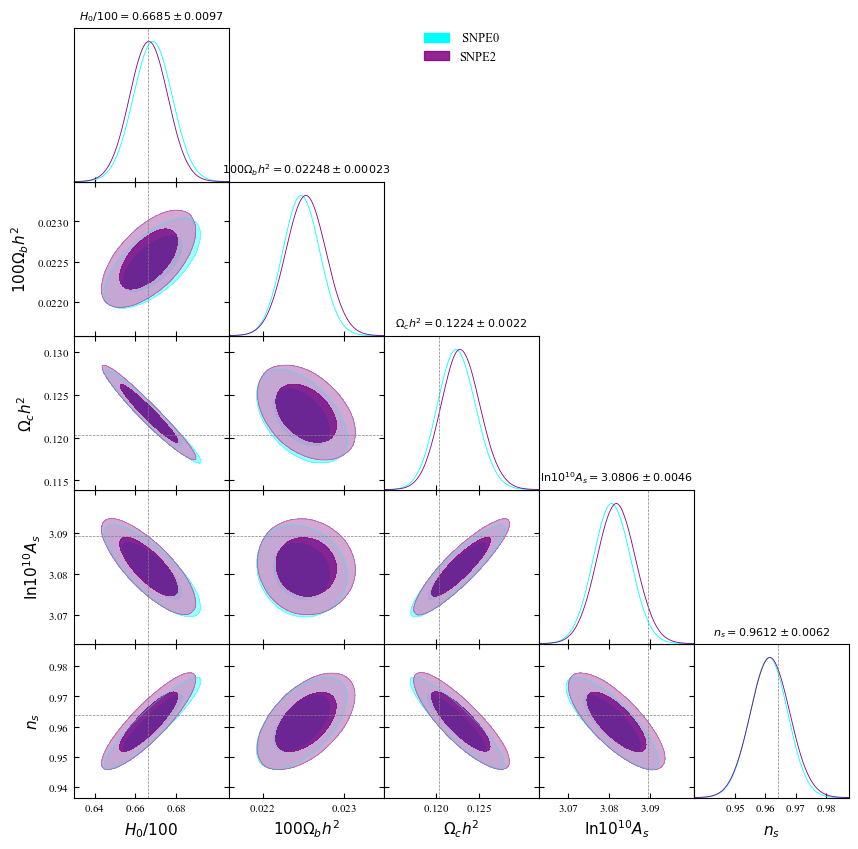

In [33]:
from getdist import plots
from getdist import MCSamples

%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

snpe_samples0 = MCSamples(samples=np.array(posterior_samples0), names=param_names, labels=param_labels)
snpe_samples1 = MCSamples(samples=np.array(posterior_samples1), names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([snpe_samples0, snpe_samples1], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' SNPE0', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

In [28]:
thetas = []
theta = proposal.sample(sample_shape = (5, 100000))

Drawing 500000 posterior samples:   0%|          | 0/500000 [00:00<?, ?it/s]

(array([3.30000e+01, 1.19000e+03, 1.48570e+04, 7.62440e+04, 1.69069e+05,
        1.60297e+05, 6.55980e+04, 1.17800e+04, 9.06000e+02, 2.60000e+01]),
 array([0.6219675 , 0.630986  , 0.64000446, 0.649023  , 0.6580415 ,
        0.66705996, 0.67607844, 0.6850969 , 0.69411546, 0.70313394,
        0.7121524 ], dtype=float32),
 <a list of 10 Patch objects>)

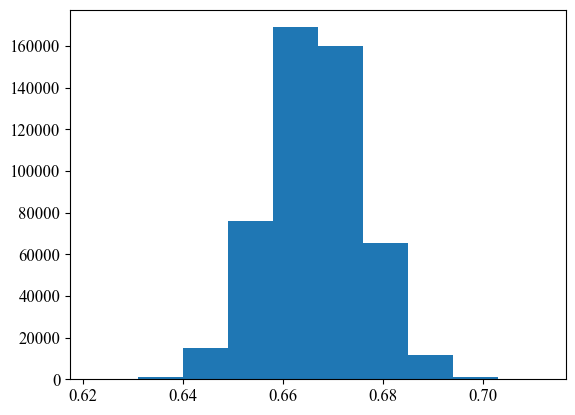

In [32]:
plt.hist(theta[:, 0])

In [34]:
num_rounds = 2
x_o = observed_dataset

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=5000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

import pickle
with open('sbi_posteriors/posteriors_snpe_3_plus_2_rounds_3000sim_5000sim.pkl', 'wb') as file:
    pickle.dump(posteriors, file)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

In [35]:
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=5000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

import pickle
with open('sbi_posteriors/posteriors_snpe_3_plus_2_rounds_3000sim_5000sim_v2.pkl', 'wb') as file:
    pickle.dump(posteriors, file)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

In [36]:
posterior_samples1 = posteriors[-1].sample((1000000,))
posterior_samples0 = posteriors[0].sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


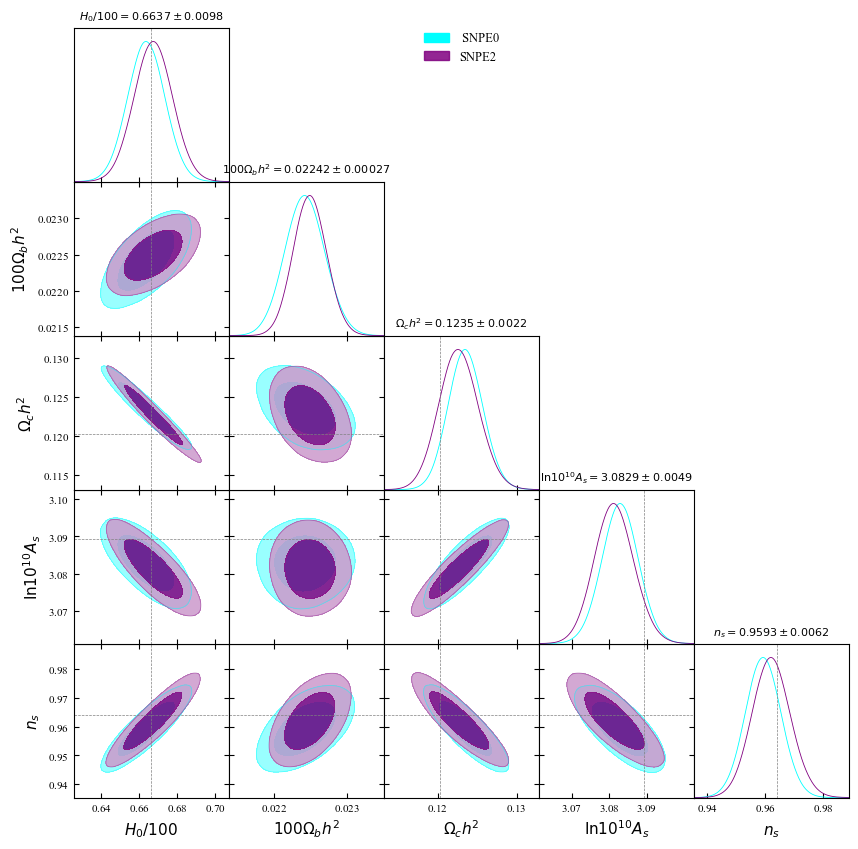

In [37]:
param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

snpe_samples0 = MCSamples(samples=np.array(posterior_samples0), names=param_names, labels=param_labels)
snpe_samples1 = MCSamples(samples=np.array(posterior_samples1), names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([snpe_samples0, snpe_samples1], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' SNPE0', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

In [38]:
np.save('sbi_samples/samples_snpe_0.npy',posterior_samples0 )
np.save('sbi_samples/samples_snpe_1.npy',posterior_samples1 )

In [39]:
print(len(posteriors))

4


## AGAIN

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats

#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = 'noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(obs):
    cat = np.array(obs['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2499]}

sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]

def find_bounds(k):
    hw = 24 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

In [44]:
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

def simulator_wrapper(params):
    dict_cl = simulator(np.array(params))
    cltt = noise(dict_cl)['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)
   
observed_dataset = simulator_wrapper(pl)
print(observed_dataset)

tensor([  41.2041, -376.2180, -331.3544,   83.1167, -456.4544],
       dtype=torch.float64)


In [46]:
import pickle 
with open ('samples/samples_10000_sim_wishart.pkl', 'rb') as file:
    sims = pickle.load(file)

In [48]:
cls = sims['x']
params = sims['z']


In [53]:
prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(params, dtype = torch.float32), 
                                         torch.tensor(cls, dtype = torch.float32))


In [54]:
density_estimator = inference.train(learning_rate=1e-4)

 Neural network successfully converged after 253 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in


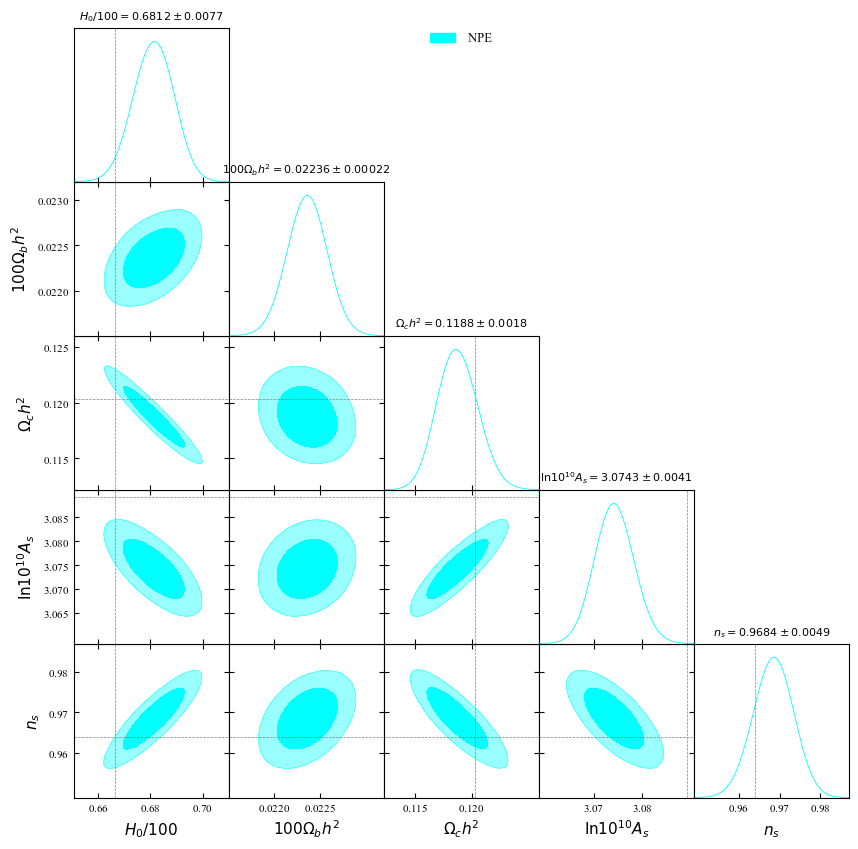

In [55]:
simulator_sbi, prior = prepare_for_sbi(simulator_wrapper, prior)

posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(observed_dataset)

posterior_samples = posterior.sample((1000000,))

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

npe_1r = MCSamples(samples=np.array(posterior_samples), names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot(npe_1r, filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' NPE', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

In [56]:
posteriors_snpe_new = []
thetas = []
xs = []

posteriors_snpe_new.append(posterior)
proposal = posterior.set_default_x(observed_dataset)

In [57]:
num_rounds = 3

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=5000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_snpe_new.append(posterior)
    proposal = posterior.set_default_x(observed_dataset)
    thetas.append(theta)
    xs.append(x)



Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.

In [58]:
posterior = inference.build_posterior(density_estimator)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


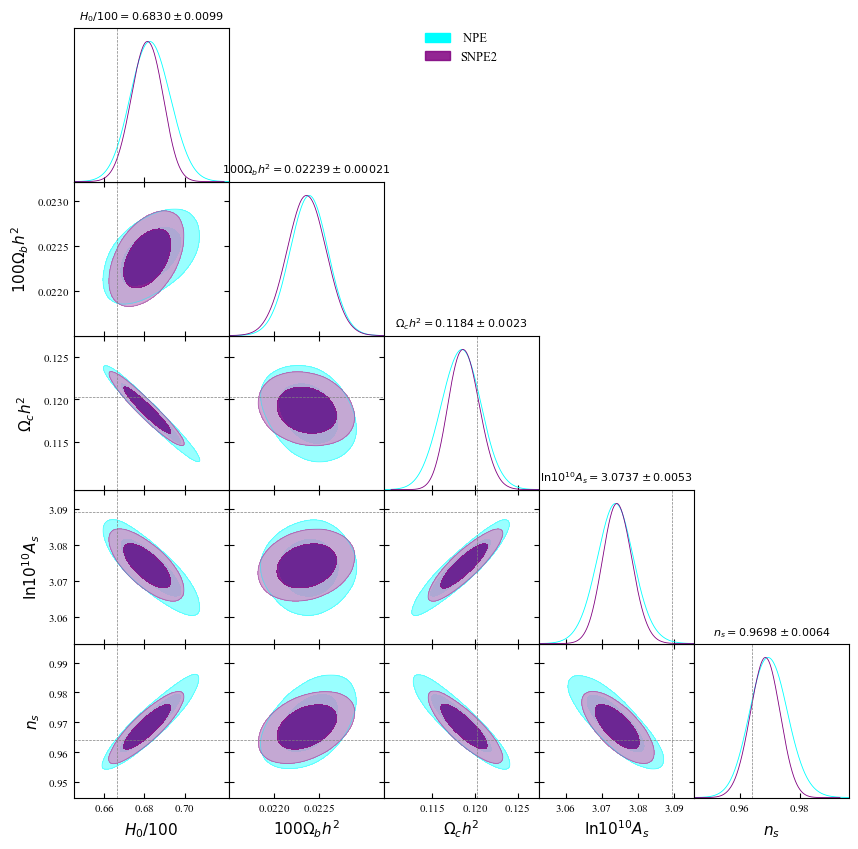

In [60]:
posterior_samples = posteriors_snpe_new[-1].sample((1000000,))
posterior_samples1 = posteriors_snpe_new[0].sample((1000000,))

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

npe_1r = MCSamples(samples=np.array(posterior_samples), names=param_names, labels=param_labels)
npe_2r = MCSamples(samples=np.array(posterior_samples1), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([npe_1r, npe_2r], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' NPE', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

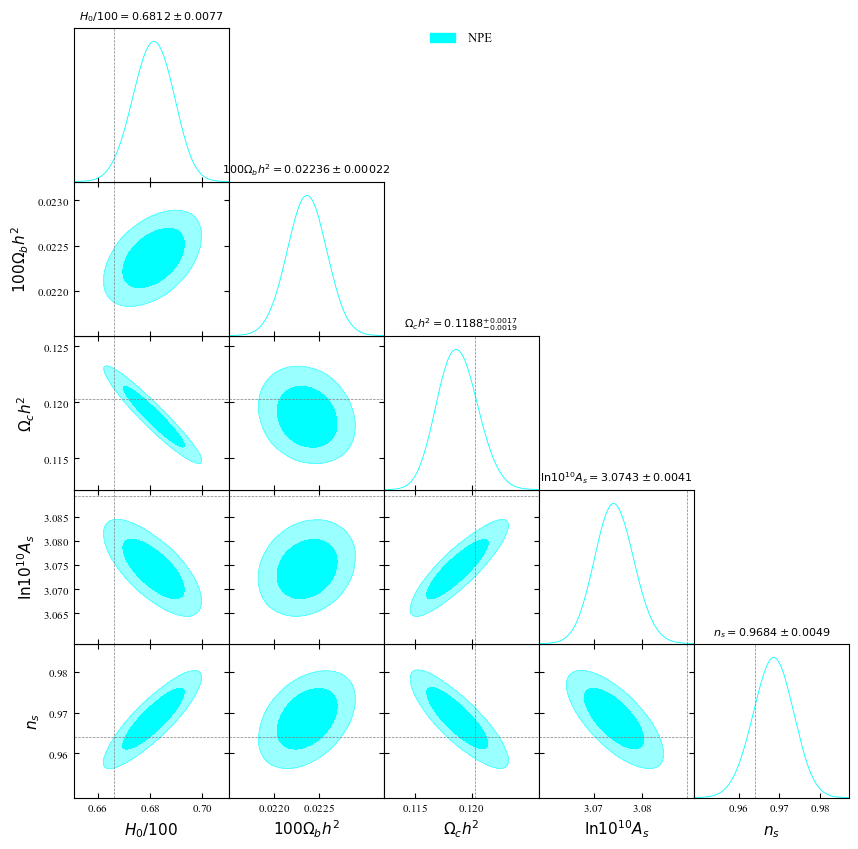

In [61]:
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([npe_2r], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' NPE', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,
          4.,   2.,   3.,   2.,   4.,   8.,   9.,   7.,   6.,  13.,  15.,
         19.,  17.,  16.,  26.,  28.,  33.,  40.,  55.,  40.,  52.,  71.,
         62.,  70.,  86.,  83., 117., 106., 106., 133., 130., 109., 142.,
        129., 123., 140., 142., 114., 119., 148., 141., 168., 131., 150.,
        154., 144., 119.,  99., 105., 113., 103.,  84., 111.,  96.,  70.,
         86.,  71.,  65.,  50.,  41.,  47.,  48.,  37.,  28.,  29.,  30.,
         17.,  19.,  20.,  13.,  15.,  11.,   9.,   8.,   8.,   4.,   6.,
          2.,   4.,   3.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,
          2.]),
 array([0.64419526, 0.6449648 , 0.64573437, 0.646504  , 0.64727354,
        0.6480431 , 0.64881265, 0.6495822 , 0.65035176, 0.6511214 ,
        0.65189093, 0.6526605 , 0.65343004, 0.6541996 , 0.65496916,
        0.6557388 , 0.6565083 , 0.6572779 , 0.65804744, 0.658817  ,
        0.65958655, 0.66035616, 0.6611257 , 0.

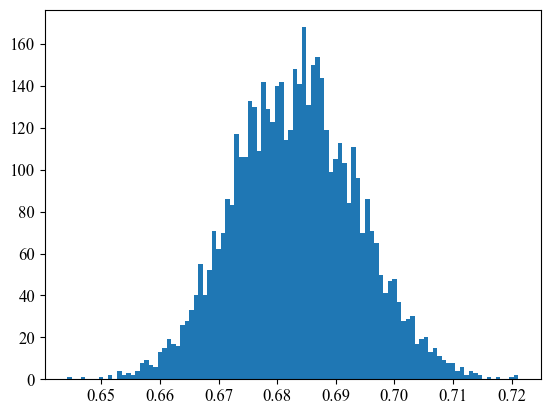

In [63]:
plt.hist(thetas[-1][:, 0], bins = 100)

In [65]:
density_estimator = inference.append_simulations(
        thetas[-1], xs[-1], proposal=proposal
    ).train(learning_rate=1e-7)
posterior = inference.build_posterior(density_estimator)
posteriors_snpe_new.append(posterior)

Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


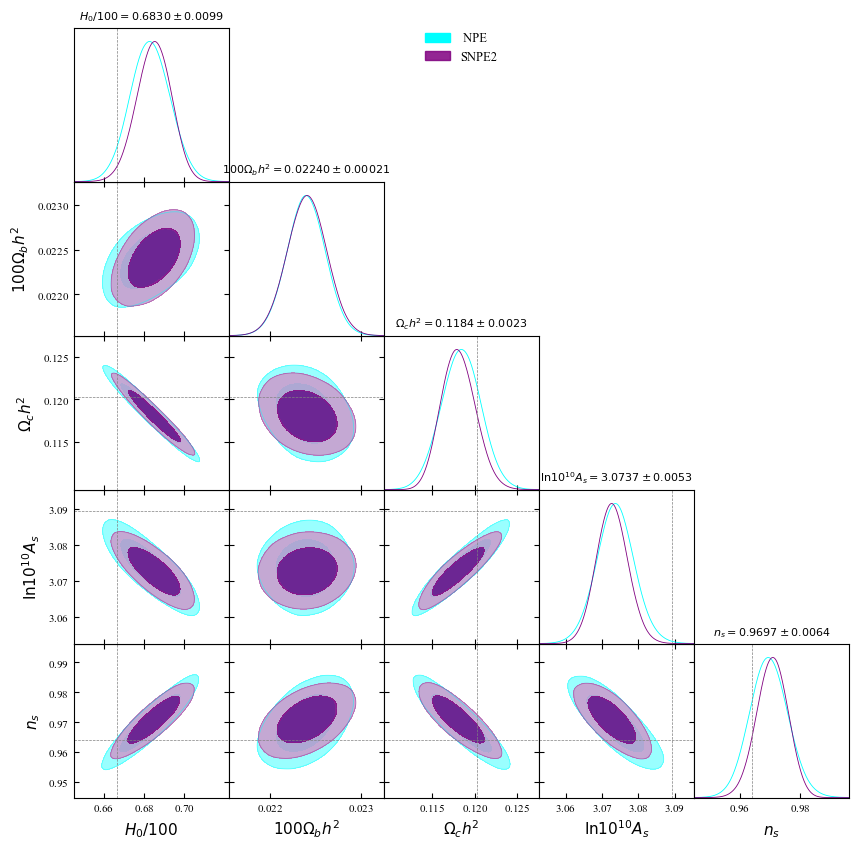

In [69]:
posterior.set_default_x(observed_dataset)
posterior_samples = posterior.sample((1000000,))
posterior_samples1 = posteriors_snpe_new[1].sample((1000000,))

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

npe_1r = MCSamples(samples=np.array(posterior_samples), names=param_names, labels=param_labels)
npe_2r = MCSamples(samples=np.array(posterior_samples1), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([npe_1r, npe_2r], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' NPE', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                
                );

# AGAIN FINAL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats

#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = 'noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(obs):
    cat = np.array(obs['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2499]}

sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]

def find_bounds(k):
    hw = 24 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

path='LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

2024-04-15 19:08:27.828757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

def simulator_wrapper(params):
    dict_cl = simulator(np.array(params))
    cltt = noise(dict_cl)['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)

observed_dataset = simulator_wrapper(pl)
print(observed_dataset)

tensor([  38.4910, -374.2171, -330.2570,   83.0376, -457.2168],
       dtype=torch.float64)


In [36]:
import pickle 
with open ('samples/samples_10000_sim_wishart.pkl', 'rb') as file:
    sims = pickle.load(file)

cls = sims['x']
params = sims['z']

In [37]:
print(cls[0])
print(params[0])

[  57.918106 -380.03314  -333.3434     92.56037  -455.4835  ]
[0.711917   0.023041   0.11872233 3.0918396  0.97982085]


In [10]:
test = simulator_wrapper(params[0])
print(test)

tensor([  57.7461, -378.6891, -332.4419,   90.9165, -454.7246],
       dtype=torch.float64)


In [14]:
prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(params, dtype = torch.float32), 
                                         torch.tensor(cls, dtype = torch.float32))

In [15]:
density_estimator = inference.train()

 Neural network successfully converged after 122 epochs.

In [16]:
posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(observed_dataset)
posterior_samples = posterior.sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in


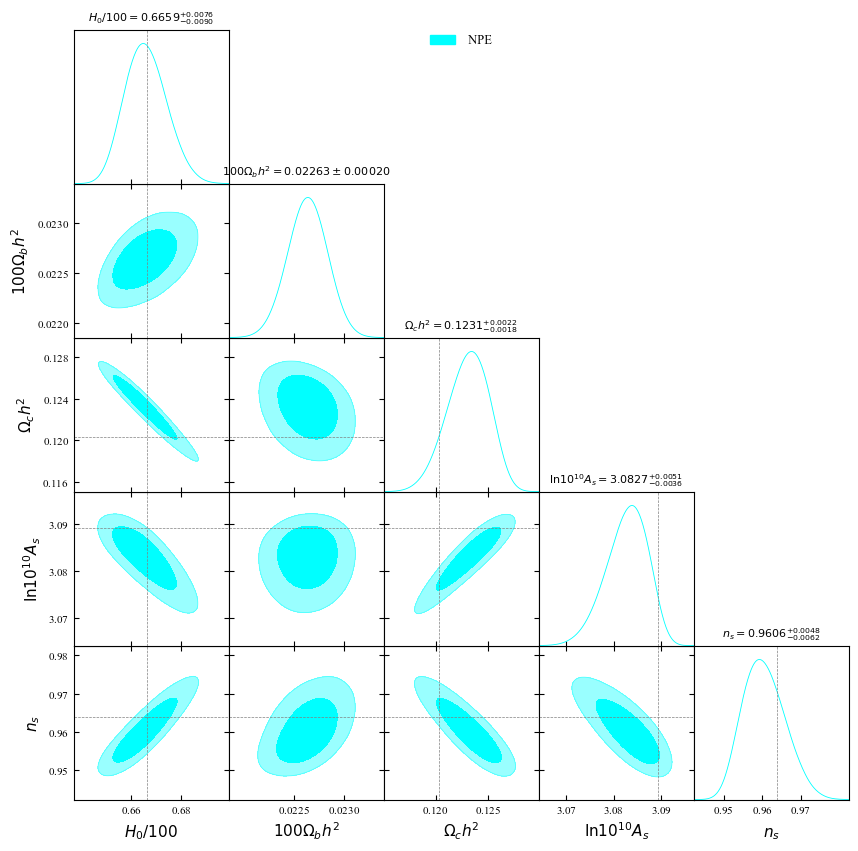

In [18]:
from getdist import plots
from getdist import MCSamples

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

npe_1r = MCSamples(samples=np.array(posterior_samples), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot(npe_1r, filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' NPE', 'SNPE2'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [19]:
num_rounds = 3
posteriors_final = []
thetas_final = []
xs_final = []

posteriors_final.append(posterior)
thetas_final.append(params)
xs_final.append(cls)


for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=5000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_final.append(posterior)
    proposal = posterior.set_default_x(observed_dataset)
    thetas_final.append(theta)
    xs_final.append(x)

np.save('thetas_final.npy', thetas_final)
np.save('xs_final.npy', xs_final)

import pickle 
with open('posteriors_snpe_final_4_rounds.pkl', 'wb') as file:
    pickle.dump(posteriors_final, file)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [21]:
simulator_sbi, prior = prepare_for_sbi(simulator_wrapper, prior)

In [27]:
for _ in range(1):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=10000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_final.append(posterior)
    proposal = posterior.set_default_x(observed_dataset)
    thetas_final.append(theta)
    xs_final.append(x)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

In [29]:
import pickle 
with open('posteriors_snpe_final_3_rounds.pkl', 'wb') as file:
    pickle.dump(posteriors_final, file)

In [83]:
posterior_samples_2r = posteriors_final[3].set_default_x(observed_dataset2).sample((1000000,))
posterior_samples_1r = posteriors_final[1].set_default_x(observed_dataset2).sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


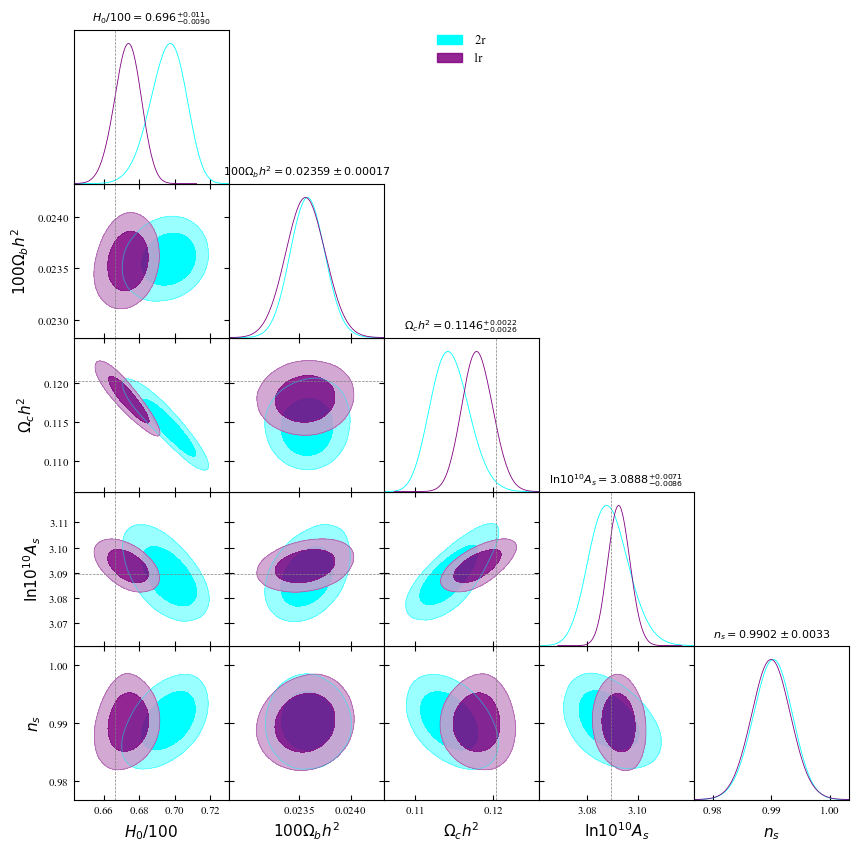

In [84]:
npe_1r = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
npe_2r = MCSamples(samples=np.array(posterior_samples_2r), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([npe_2r, npe_1r], filled=True, 
                contour_colors = ['cyan', 'purple'],
                legend_labels=[' 2r', '1r'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [60]:
print(len(posteriors_final))


4


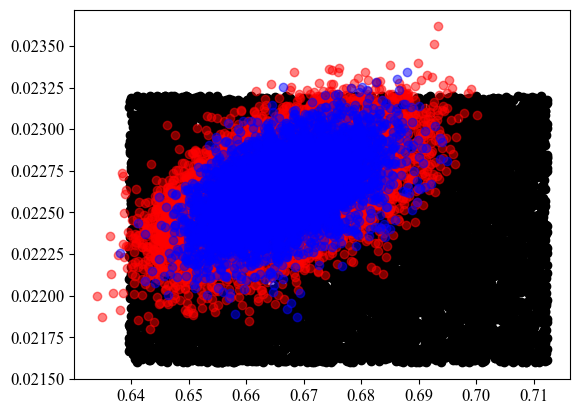

In [52]:
plt.scatter(thetas_final[0][:, 0], thetas_final[0][:, 1] ,color = 'black')
plt.scatter(thetas_final[2][:, 0], thetas_final[2][:, 1],color = 'red', alpha = 0.5)
plt.scatter(thetas_final[1][:, 0], thetas_final[1][:, 1],color = 'blue', alpha = 0.5)


In [55]:
print(len(thetas_final))

3


In [53]:
n = [1, 2, 3, 4, 5]
print(n[-1])

5


In [57]:

density_estimator = inference.append_simulations(
        thetas_final[2], xs_final[2], proposal = proposal).train()

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

In [58]:
posterior = inference.build_posterior(density_estimator)
posteriors_final.append(posterior)

In [138]:
def simulator2(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
def simulator_wrapper2(params):
    dict_cl = simulator2(np.array(params))
    cltt = dict_cl['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)

def simulator_wrapper3(params):
    dict_cl = simulator2(np.array(params))
    cltt = noise(dict_cl)['TT']
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return torch.tensor(output)

observed_dataset2 = simulator_wrapper2(pl)
print(observed_dataset2)

tensor([-151.4666, -328.9475, -276.2863,  429.0325,   11.7849],
       dtype=torch.float64)


In [74]:
inference_npe = SNPE()

inference_npe = inference_npe.append_simulations(torch.tensor(params, dtype = torch.float32), 
                                         torch.tensor(cls, dtype = torch.float32))

density_estimator_npe = inference_npe.train()

posterior_npe = inference_npe.build_posterior(density_estimator_npe)
posterior_npe.set_default_x(observed_dataset2)
posterior_samples_npe = posterior_npe.sample((1000000,))



 Neural network successfully converged after 127 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in
Removed no burn in


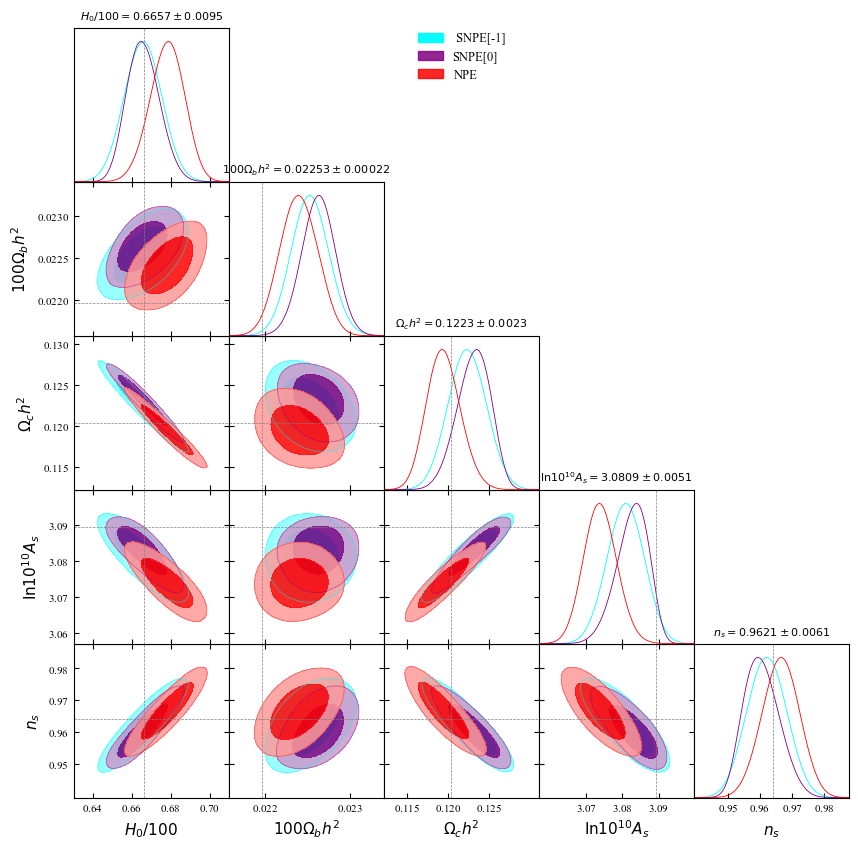

In [68]:
npe_1r = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
npe_2r = MCSamples(samples=np.array(posterior_samples_2r), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(posterior_samples_npe), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([npe_2r, npe_1r, npe], filled=True, 
                contour_colors = ['cyan', 'purple', 'red'],
                legend_labels=[' SNPE[-1]', 'SNPE[0]', 'NPE'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [71]:
data = np.loadtxt('montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [data[i][2]-0.032-3e-3-0.0105+0.00920, (data[i][3]-0.075)/100, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


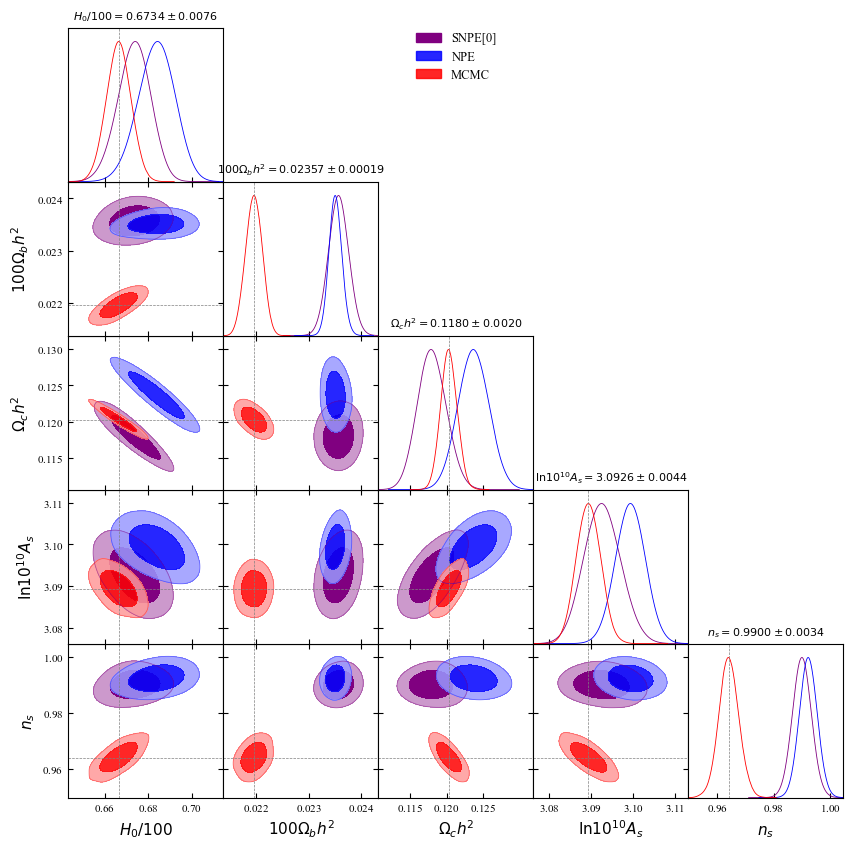

In [85]:
npe_1r = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
npe_2r = MCSamples(samples=np.array(posterior_samples_2r), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(posterior_samples_npe), names=param_names, labels=param_labels)
mcmc = MCSamples(samples=np.array(data_reshape), names=param_names, labels=param_labels)


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ npe_1r, npe, mcmc], filled=True, 
                contour_colors = [ 'purple', 'blue', 'red'],
                legend_labels=[ 'SNPE[0]', 'NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [95]:
proposal = posterior_npe.set_default_x(observed_dataset2)

inference = SNPE(prior = prior)
inference = inference.append_simulations(thetas_final[1], 
                                         xs_final[1], proposal = proposal)

In [96]:
density_estimator = inference.train()

posterior_snpe = inference.build_posterior(density_estimator)
posterior_snpe.set_default_x(observed_dataset2)
posterior_samples_snpe = posterior_snpe.sample((1000000,))


Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [98]:
with open('samples_npe_moped_final.pkl', 'rb') as file:
    npe_samples = pickle.load(file)

Removed no burn in
Removed no burn in
Removed no burn in


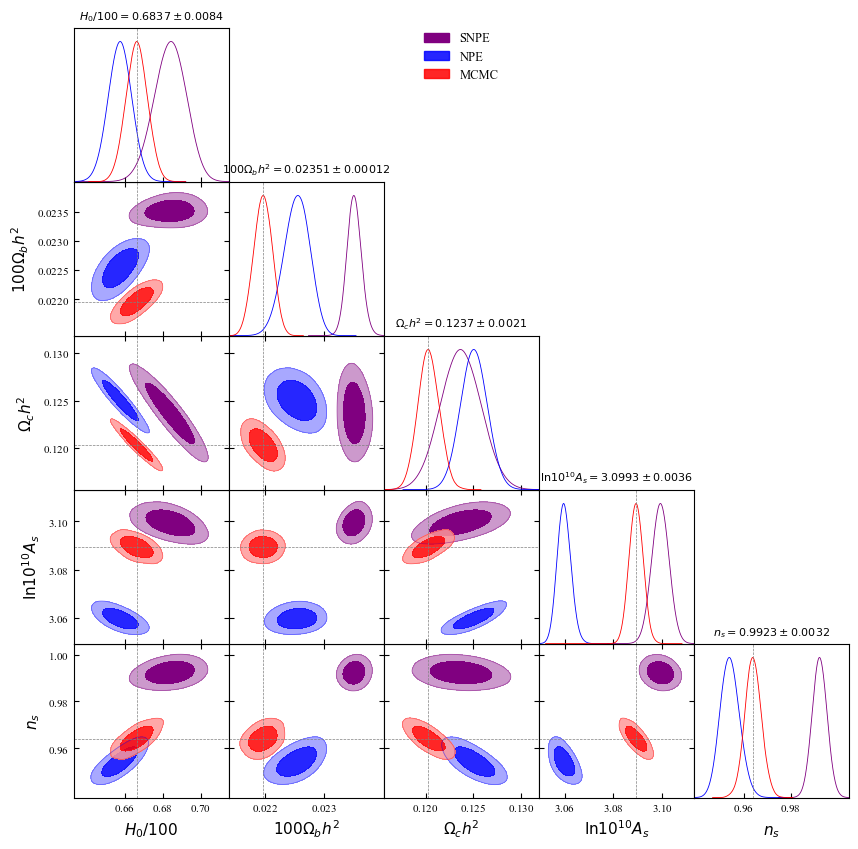

In [99]:
snpe = MCSamples(samples=np.array(posterior_samples_npe), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(npe_samples), names=param_names, labels=param_labels)
mcmc = MCSamples(samples=np.array(data_reshape), names=param_names, labels=param_labels)



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe, npe, mcmc], filled=True, 
                contour_colors = [ 'purple', 'blue', 'red'],
                legend_labels=[ 'SNPE', 'NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [139]:
num_rounds = 3
posteriors_final22 = []
thetas_final22 = []
xs_final22 = []
prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))
simulator_sbi, prior = prepare_for_sbi(simulator_wrapper3, prior)
inference_snpe_final = SNPE(prior=prior)
proposal = prior


for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=3000)
    density_estimator_final = inference_snpe_final.append_simulations( theta, x, proposal=proposal).train()
    posterior_snpe_final = inference_snpe_final.build_posterior(density_estimator_final)
    posteriors_final22.append(posterior_snpe_final)
    proposal = posterior_snpe_final.set_default_x(observed_dataset2)
    thetas_final22.append(theta)
    xs_final22.append(x)

import pickle 
with open('posteriors_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(posteriors_final22, file)

with open('thetas_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(thetas_final22, file)

with open('xs_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(xs_final22, file)

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

 Neural network successfully converged after 217 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.

In [103]:
print(param_min)

[0.5012724635390788, 0.018559898197142734, 0.08034454022240717, 2.991962391414518, 0.8652648943279388]


In [140]:

posterior_samples_1r = posteriors_final22[0].sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [141]:
posterior_samples_3r = posteriors_final22[-1].set_default_x(observed_dataset2).sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


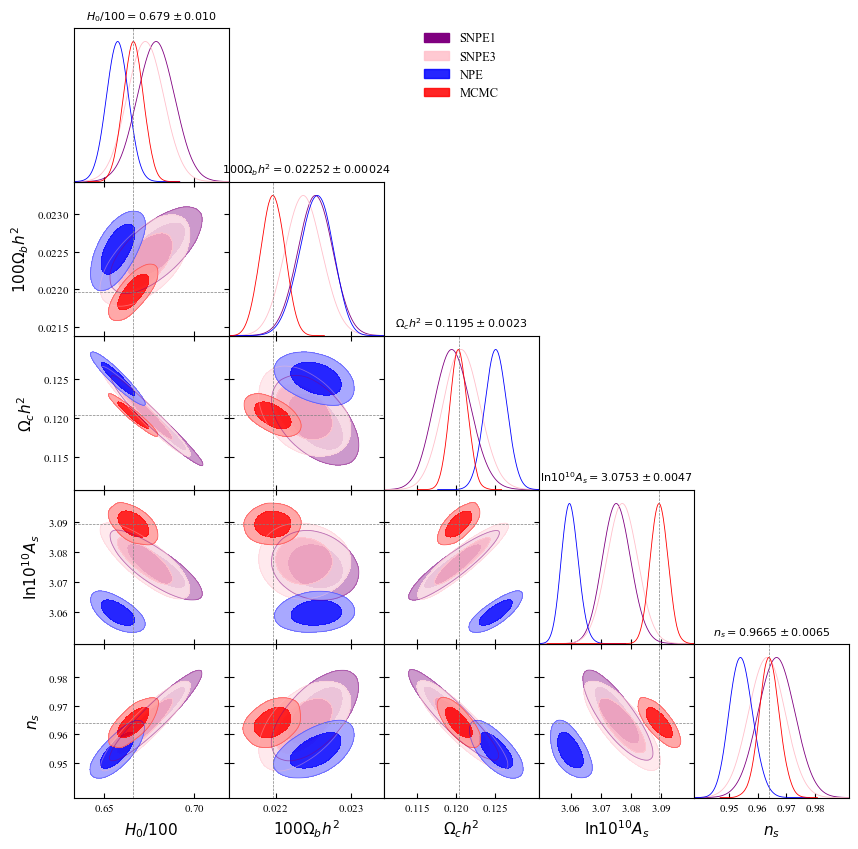

In [142]:
snpe1 = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
snpe3 = MCSamples(samples=np.array(posterior_samples_3r), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(npe_samples), names=param_names, labels=param_labels)
mcmc = MCSamples(samples=np.array(data_reshape), names=param_names, labels=param_labels)



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe1, snpe3, npe, mcmc], filled=True, 
                contour_colors = [ 'purple','pink', 'blue', 'red'],
                legend_labels=[ 'SNPE1','SNPE3', 'NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

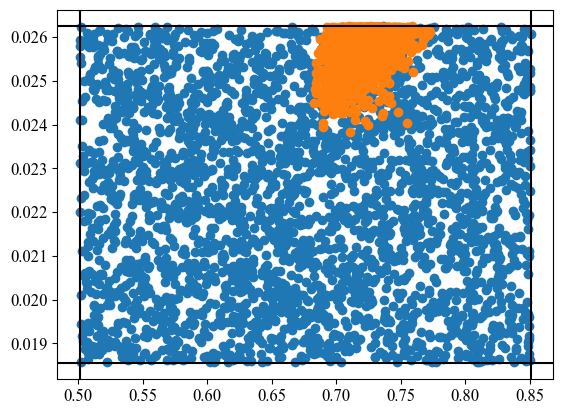

In [120]:
plt.scatter(thetas_final2[0][:, 0], thetas_final2[0][:, 1])
plt.scatter(thetas_final2[2][:, 0], thetas_final2[2][:, 1])
plt.axhline(param_min[1], color = 'black')
plt.axhline(param_max[1], color = 'black')
plt.axvline(param_min[0], color = 'black')
plt.axvline(param_max[0], color = 'black')

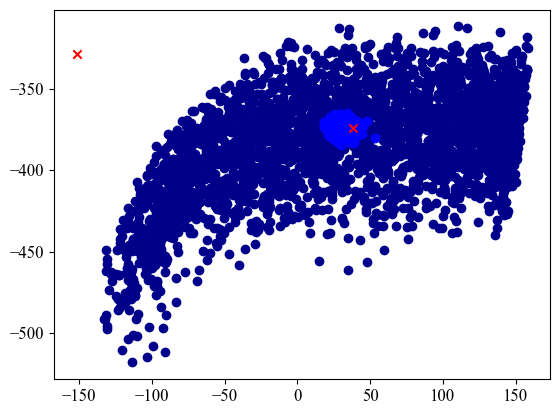

In [137]:
plt.scatter(xs_final2[0][:, 0], xs_final2[0][:, 1], color = 'darkblue')
plt.scatter(xs_final2[2][:, 0], xs_final2[2][:, 1], color = 'blue')
plt.scatter(observed_dataset[0], observed_dataset[1], marker= 'x', color = 'red')
plt.scatter(observed_dataset2[0], observed_dataset2[1], marker= 'x', color = 'red')

In [143]:
theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=10000)
density_estimator_final = inference_snpe_final.append_simulations( theta, x, proposal=proposal).train()
posterior_snpe_final = inference_snpe_final.build_posterior(density_estimator_final)
proposal = posterior_snpe_final.set_default_x(observed_dataset2)
posteriors_final22.append(posterior_snpe_final)
thetas_final22.append(theta)
xs_final22.append(x)

import pickle 
with open('posteriors_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(posteriors_final22, file)

with open('thetas_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(thetas_final22, file)

with open('xs_snpe_final_3_rounds_v3.pkl', 'wb') as file:
    pickle.dump(xs_final22, file)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

In [144]:

posterior_samples_1r = posteriors_final22[0].sample((1000000,))

posterior_samples_4r = posteriors_final22[-1].sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


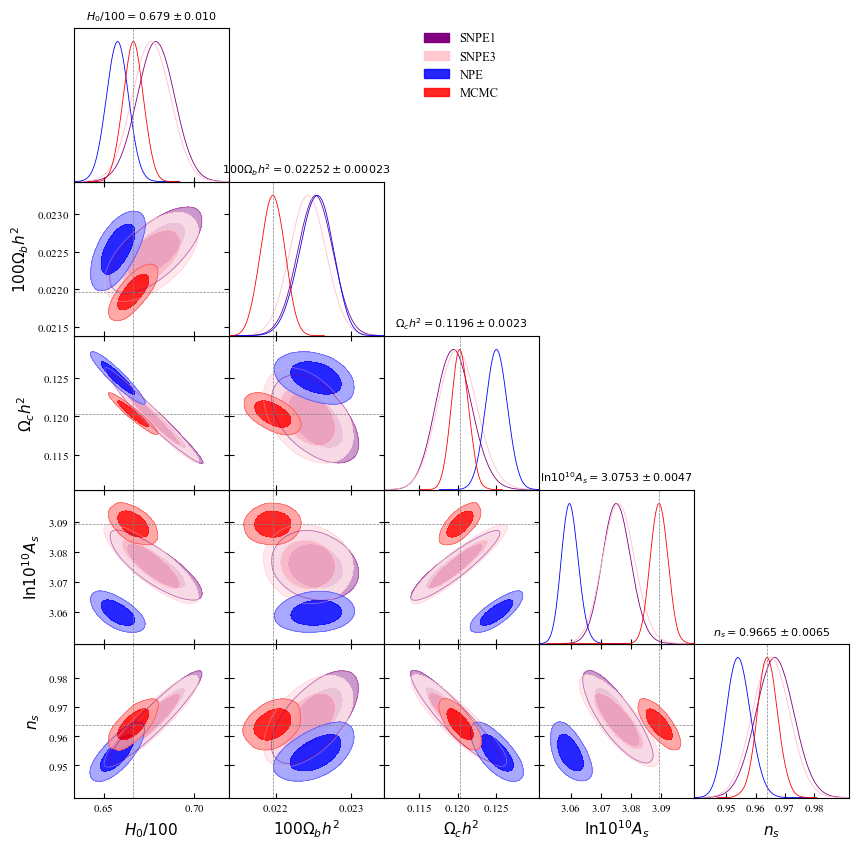

In [145]:
snpe1 = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
snpe4 = MCSamples(samples=np.array(posterior_samples_4r), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(npe_samples), names=param_names, labels=param_labels)
mcmc = MCSamples(samples=np.array(data_reshape), names=param_names, labels=param_labels)



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe1, snpe4, npe, mcmc], filled=True, 
                contour_colors = [ 'purple','pink', 'blue', 'red'],
                legend_labels=[ 'SNPE1','SNPE3', 'NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

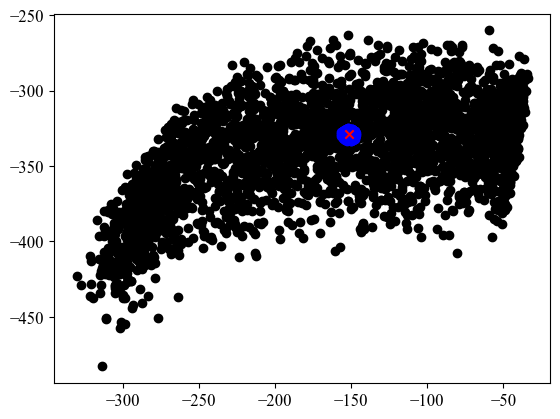

In [148]:
plt.scatter(xs_final22[0][:, 0],xs_final22[0][:, 1] , color = 'black')
plt.scatter(xs_final22[-1][:, 0],xs_final22[-1][:, 1] , color = 'blue')
plt.scatter(observed_dataset2[0],observed_dataset2[1], marker = 'x', color = 'red' )

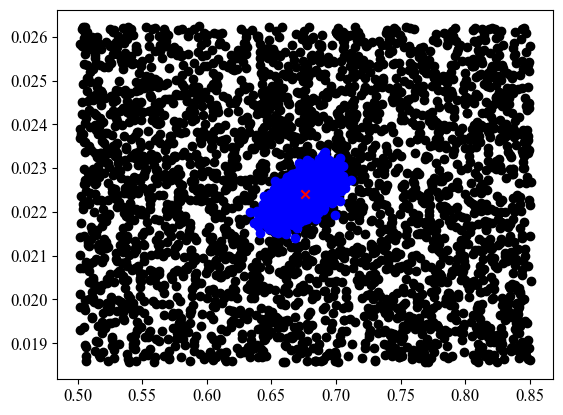

In [149]:
plt.scatter(thetas_final22[0][:, 0],thetas_final22[0][:, 1] , color = 'black')
plt.scatter(thetas_final22[-1][:, 0],thetas_final22[-1][:, 1] , color = 'blue')
plt.scatter(pl[0],pl[1], marker = 'x', color = 'red' )

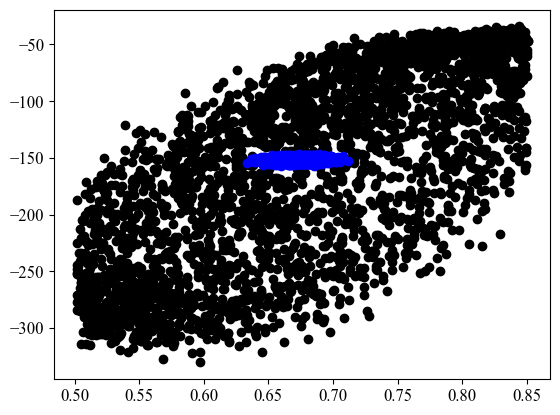

In [150]:
plt.scatter(thetas_final22[0][:, 0],xs_final22[0][:, 0] , color = 'black')
plt.scatter(thetas_final22[-1][:, 0],xs_final22[-1][:, 0] , color = 'blue')

In [157]:
xs_final22[0][0]

tensor([-130.2383, -325.5725, -264.9232,  420.5734,   -0.8234])

In [156]:
simulator_wrapper3(thetas_final22[0][0])

tensor([-130.9704, -325.2366, -264.7460,  419.5909,   -0.9666],
       dtype=torch.float64)

In [159]:
print(len(thetas_final22[-1]))
print(len(xs_final22[-1]))

10000
10000


In [160]:
inference_snpe_final_v2 = SNPE(prior=prior)
density_estimator_final_v2 = inference_snpe_final_v2.append_simulations( thetas_final22[-1], xs_final22[-1], proposal=proposal).train(learning_rate = 1e-6)
posterior_snpe_final_v2 = inference_snpe_final_v2.build_posterior(density_estimator_final_v2)
proposal_snpe_final = posterior_snpe_final.set_default_x(observed_dataset2)


Using SNPE-C with atomic loss
 Neural network successfully converged after 312 epochs.

In [163]:
proposal_snpe_final = posterior_snpe_final_v2.set_default_x(observed_dataset)
posterior_samples_fr = posterior_snpe_final_v2.sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


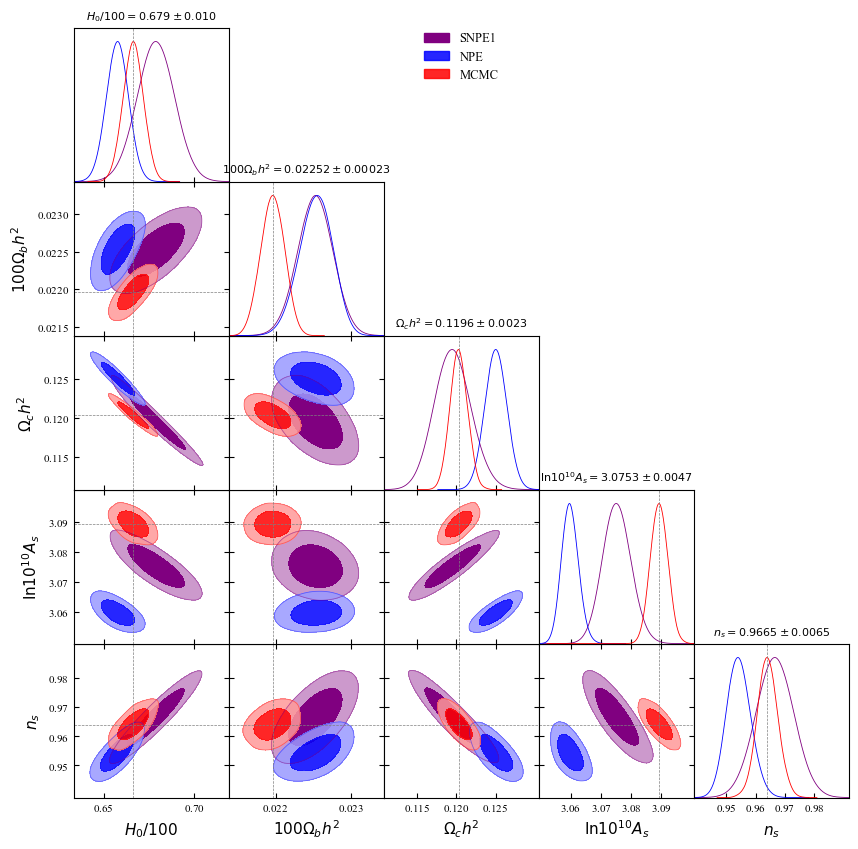

In [165]:
snpe1 = MCSamples(samples=np.array(posterior_samples_1r), names=param_names, labels=param_labels)
snpef = MCSamples(samples=np.array(posterior_samples_fr), names=param_names, labels=param_labels)
npe = MCSamples(samples=np.array(npe_samples), names=param_names, labels=param_labels)
mcmc = MCSamples(samples=np.array(data_reshape), names=param_names, labels=param_labels)



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe1, npe, mcmc], filled=True, 
                contour_colors = [ 'purple', 'blue', 'red'],
                legend_labels=[ 'SNPE1','NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963/100, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'},
                title_limit=1,
                );

In [166]:
import swyft

In [189]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds=None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sample_z = swyft.RectBoundSampler([stats.uniform(param_min[0], 48*sigss[0]),      
                                  stats.uniform(param_min[1], 48*sigss[1]),  
                                  stats.uniform(param_min[2], 48*sigss[2]),
                                  stats.uniform(param_min[3], 48*sigss[3]),  
                                  stats.uniform(param_min[4], 48*sigss[4])], 
                                  bounds = bounds)
    def calc_cmb(self, z):
        dict_cl = simulator(np.array(z))
        cltt = noise(dict_cl)['TT']
        output = cltt*ells
        return torch.tensor(output)

    def build (self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.calc_cmb, z)
        x = graph.node('x', lambda m: m,  m)
sim = Simulator()

In [190]:
shapes, dtypes = sim.get_shapes_and_dtypes()
store = swyft.ZarrStore(".nre_code/example_zarr_store")
store.init(10000, 64, shapes, dtypes) 

In [181]:
dm = swyft.SwyftDataModule(store, batch_size = 32)

In [199]:
print(store['x'][2])

[0. 0. 0. ... 0. 0. 0.]


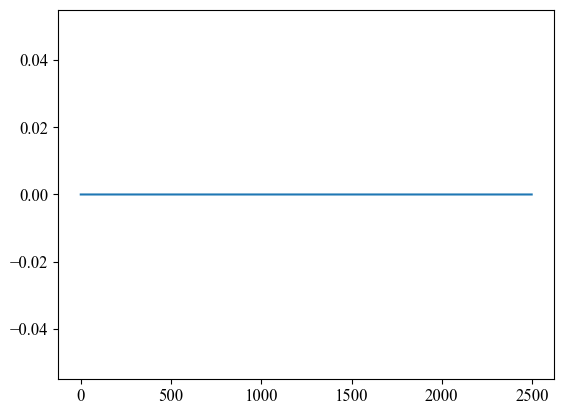

In [201]:
plt.plot(store['x'][0])

In [203]:
samples_store = np.load('samples_store.npy')
pars_store = np.load('pars_store.npy')